In [37]:
import pandas as pd
# Load the dataset
file_path = 'Movies_new_FTD_1.csv'
movies_df = pd.read_csv(file_path)

# Display the first few rows of the dataframe
movies_df.head()


,budget,genres,original_language,popularity,production_companies,production_countries,revenue,runtime,title,vote_average,vote_count,cast,release_year,release_month,release_day,Profit,roi
0,200000000,7,4,37.668301,1,141,310669540,140.0,Robin Hood,6.2,1398,1,2010,5,12,110669540,55.334770
1,180000000,3,4,42.990906,1,141,372234864,113.0,The Golden Compass,5.8,1303,1,2007,12,4,192234864,106.797147
2,150000000,9,4,21.939663,1,2086,836297228,150.0,Transformers: Revenge of the Fallen,6.0,3138,1,2009,6,19,686297228,457.531485
3,170000000,13,4,73.795050,1,2086,400062763,125.0,TRON: Legacy,6.3,2841,1,2010,12,10,230062763,135.331037
4,200000000,2,4,49.986590,11,2086,559852396,106.0,Cars 2,5.8,2033,1,2011,6,11,359852396,179.926198


In [38]:
# First, let's examine the distribution of revenue to determine the bins for categorization
revenue_descriptive_stats = movies_df['revenue'].describe(percentiles=[0.25, 0.5, 0.75])
revenue_descriptive_stats


count    2.965000e+03
mean     9.743101e+07
std      1.259217e+08
min      5.000000e+00
25%      1.687267e+07
50%      5.227748e+07
75%      1.278694e+08
max      9.243176e+08
Name: revenue, dtype: float64

In [39]:
# Categorizing 'revenue' into four categories based on the quartiles
bins = [movies_df['revenue'].min()-1, 
        revenue_descriptive_stats['25%'], 
        revenue_descriptive_stats['50%'], 
        revenue_descriptive_stats['75%'], 
        movies_df['revenue'].max()]

# number of each class needed
labels = ['Low', 'Medium', 'High', 'Very_High']
movies_df['revenue_category'] = pd.cut(movies_df['revenue'], bins=bins, labels=labels, include_lowest=True)

# Drop the 'title' column and 'revenue' as we now have 'revenue_category'
movies_df_preprocessed = movies_df.drop(['title', 'revenue'], axis=1)

# Let's see the distribution of the new revenue_category column
revenue_category_distribution = movies_df_preprocessed['revenue_category'].value_counts(normalize=True)
revenue_category_distribution, movies_df_preprocessed.head()


(Low          0.250253
 Medium       0.249916
 High         0.249916
 Very_High    0.249916
 Name: revenue_category, dtype: float64,
       budget  genres  original_language  popularity  production_companies  \
 0  200000000       7                  4   37.668301                     1   
 1  180000000       3                  4   42.990906                     1   
 2  150000000       9                  4   21.939663                     1   
 3  170000000      13                  4   73.795050                     1   
 4  200000000       2                  4   49.986590                    11   
 
    production_countries  runtime  vote_average  vote_count  cast  \
 0                   141    140.0           6.2        1398     1   
 1                   141    113.0           5.8        1303     1   
 2                  2086    150.0           6.0        3138     1   
 3                  2086    125.0           6.3        2841     1   
 4                  2086    106.0           5.8     

In [40]:
from sklearn.model_selection import train_test_split

# Splitting the data into features (X) and labels (y)
X_original = movies_df_preprocessed.drop('revenue_category', axis=1)
y_original = movies_df_preprocessed['revenue_category']

# Splitting the original data into training and testing sets
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42, stratify=y_original
)

# Display the shapes of the train and test sets
(X_train_original.shape, X_test_original.shape, y_train_original.shape, y_test_original.shape)


((2372, 15), (593, 15), (2372,), (593,))

In [41]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardizing the data before applying PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_original)

# Applying PCA
pca = PCA(n_components=0.95)  # We want to retain 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Splitting the PCA-transformed data into training and testing sets
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(
    X_pca, y_original, test_size=0.2, random_state=42, stratify=y_original
)

# Display the shape of the PCA components and the variance ratio
pca_components_shape = X_pca.shape
pca_explained_variance_ratio = pca.explained_variance_ratio_

(pca_components_shape, pca_explained_variance_ratio)


((2965, 12),
 array([0.20415512, 0.11738546, 0.10048433, 0.08072334, 0.07536859,
        0.07192867, 0.06815642, 0.06262957, 0.05761635, 0.05288894,
        0.0419825 , 0.02888179]))

In [42]:
# Selecting features based on domain knowledge
features_to_select = ['budget', 'popularity', 'vote_average', 'vote_count', 'cast', 
                      'production_companies', 'production_countries']

X_feature_selected = X_original[features_to_select]

# Splitting the feature-selected data into training and testing sets
X_train_feature_selected, X_test_feature_selected, y_train_feature_selected, y_test_feature_selected = train_test_split(
    X_feature_selected, y_original, test_size=0.2, random_state=42, stratify=y_original
)

# Display the shapes of the feature-selected train and test sets
(X_train_feature_selected.shape, X_test_feature_selected.shape)


((2372, 7), (593, 7))

In [43]:
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Function to train and evaluate a model
def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    # Training the model
    model.fit(X_train, y_train)
    # Predicting the test set results
    y_pred = model.predict(X_test)
    # Evaluating the model
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Dictionary to hold the results
results = {}

# Training and evaluating models on the original dataset
svm_original = SVC(random_state=42)
results['Original_SVM'] = train_and_evaluate_model(svm_original, X_train_original, y_train_original, X_test_original, y_test_original)

decision_tree_original = DecisionTreeClassifier(random_state=42)
results['Original_DecisionTree'] = train_and_evaluate_model(decision_tree_original, X_train_original, y_train_original, X_test_original, y_test_original)

random_forest_original = RandomForestClassifier(random_state=42)
results['Original_RandomForest'] = train_and_evaluate_model(random_forest_original, X_train_original, y_train_original, X_test_original, y_test_original)

# Training and evaluating models on the PCA-transformed dataset
svm_pca = SVC(random_state=42)
results['PCA_SVM'] = train_and_evaluate_model(svm_pca, X_train_pca, y_train_pca, X_test_pca, y_test_pca)

decision_tree_pca = DecisionTreeClassifier(random_state=42)
results['PCA_DecisionTree'] = train_and_evaluate_model(decision_tree_pca, X_train_pca, y_train_pca, X_test_pca, y_test_pca)

random_forest_pca = RandomForestClassifier(random_state=42)
results['PCA_RandomForest'] = train_and_evaluate_model(random_forest_pca, X_train_pca, y_train_pca, X_test_pca, y_test_pca)

# Training and evaluating models on the feature-selected dataset
svm_feature_selected = SVC(random_state=42)
results['Feature_Selected_SVM'] = train_and_evaluate_model(svm_feature_selected, X_train_feature_selected, y_train_feature_selected, X_test_feature_selected, y_test_feature_selected)

decision_tree_feature_selected = DecisionTreeClassifier(random_state=42)
results['Feature_Selected_DecisionTree'] = train_and_evaluate_model(decision_tree_feature_selected, X_train_feature_selected, y_train_feature_selected, X_test_feature_selected, y_test_feature_selected)

random_forest_feature_selected = RandomForestClassifier(random_state=42)
results['Feature_Selected_RandomForest'] = train_and_evaluate_model(random_forest_feature_selected, X_train_feature_selected, y_train_feature_selected, X_test_feature_selected, y_test_feature_selected)

results


{'Original_SVM': 0.9730185497470489,
 'Original_DecisionTree': 0.9460370994940978,
 'Original_RandomForest': 0.9376053962900506,
 'PCA_SVM': 0.8161888701517707,
 'PCA_DecisionTree': 0.6087689713322091,
 'PCA_RandomForest': 0.7133220910623946,
 'Feature_Selected_SVM': 0.44350758853288363,
 'Feature_Selected_DecisionTree': 0.463743676222597,
 'Feature_Selected_RandomForest': 0.5615514333895447}

In [44]:
# Convert the dictionary to a DataFrame
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
results_df.reset_index(inplace=True)
results_df.rename(columns={'index': 'Model'}, inplace=True)
results_df

,Model,Accuracy
0,Original_SVM,0.973019
1,Original_DecisionTree,0.946037
2,Original_RandomForest,0.937605
3,PCA_SVM,0.816189
4,PCA_DecisionTree,0.608769
5,PCA_RandomForest,0.713322
6,Feature_Selected_SVM,0.443508
7,Feature_Selected_DecisionTree,0.463744
8,Feature_Selected_RandomForest,0.561551


In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

# Convert result to a 3x3 DataFrame
methods = ['SVM', 'DecisionTree', 'RandomForest']
datasets = ['Original', 'PCA', 'Feature_Selected']
results_df = pd.DataFrame(index=datasets, columns=methods)

# Populate the DataFrame
for dataset in datasets:
    for method in methods:
        results_df.loc[dataset, method] = results[f'{dataset}_{method}']

# Convert the DataFrame to float type for plotting
results_df = results_df.astype(float)

results_df

,SVM,DecisionTree,RandomForest
Original,0.973019,0.946037,0.937605
PCA,0.816189,0.608769,0.713322
Feature_Selected,0.443508,0.463744,0.561551


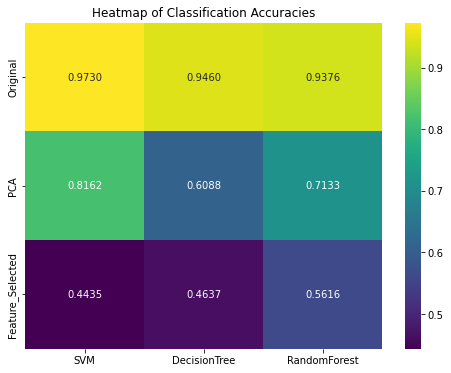

In [46]:
# Plotting the heatmap
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(results_df, annot=True, fmt=".4f", cmap='viridis')
plt.title('Heatmap of Classification Accuracies')
plt.show()

In [52]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Splitting the data into features (X) and labels (y)
X_original = movies_df_preprocessed.drop('revenue_category', axis=1)
y_original = movies_df_preprocessed['revenue_category']

# Splitting the original data into training and testing sets
X_train_original, X_test_original, y_train_original, y_test_original = train_test_split(
    X_original, y_original, test_size=0.2, random_state=42, stratify=y_original
)

# 定义模型
rf = RandomForestClassifier(random_state=42)

# 设置参数网格
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],  # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],  # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum number of samples required to be at a leaf node
}

# 运行网格搜索
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train_original, y_train_original)

# 查看最佳参数
best_params = grid_search.best_params_
print("最佳参数:", best_params)

# 使用最佳参数训练模型
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# 预测和评估
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("测试集上的准确率:", accuracy)


# # Best parameters and accuracy
# best_params = grid_search.best_params_
# best_rf = grid_search.best_estimator_
# y_pred = best_rf.predict(X_test_pca)
# accuracy = accuracy_score(y_test, y_pred)

# best_params, accuracy

Fitting 3 folds for each of 108 candidates, totalling 324 fits
最佳参数: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
测试集上的准确率: 1.0
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.4s
[C

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; total time=   0.6s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estima

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=5, n_estimators=300; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   0.3s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_estima

[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=1, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   0.5s
[CV] END max_depth=None, min_samples_leaf=2, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=2, n_estimators=200; total time=   0.4s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=100; total time=   0.2s
[CV] END max_depth=None, min_samples_leaf=4, min_samples_split=10, n_estimators=300; total time=   0.5s
[CV] END max_depth=10, min_samples_leaf=1, min_samples_split=5, n_est